In [1]:
# Part 1 - Identify the Frauds with the Self-Organizing Map

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('Credit_Card_Applications.csv')

In [3]:
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [25]:
x = df.iloc[:, :-1].values

In [26]:
y = df.iloc[:, -1].values

In [27]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
x_sc = sc.fit_transform(x)

In [28]:
# Training the self organizing map
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(x_sc)
som.train_random(data = x_sc, num_iteration=100)

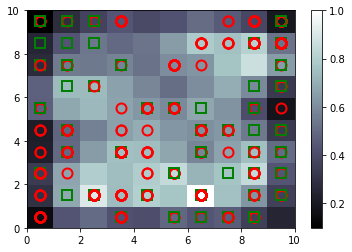

In [29]:
# Visualising the results
import matplotlib.pylab as plt
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(x_sc):
    w = som.winner(x)
    plt.plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
plt.show()

In [36]:
# finding the frauds
mappings = som.win_map(x_sc)
print(len(mappings[(2,1)]), len(mappings[(6,1)])) # (a, b) a is column, b is row, start counting from bottom left
                                                    # Index starts from 0

19 33


In [42]:
frauds = np.concatenate((mappings[(2,1)], mappings[(6, 1)]), axis = 0)
print(frauds[:1])
frauds = sc.inverse_transform(frauds)
print(frauds[:1])

[[4.29185237e-01 0.00000000e+00 7.26315789e-02 3.57142857e-01
  5.00000000e-01 7.69230769e-02 3.75000000e-01 1.45614035e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.00000000e-01 4.00000000e-02 4.20000000e-04]]
[[1.5672894e+07 0.0000000e+00 1.8580000e+01 1.0000000e+01 2.0000000e+00
  2.0000000e+00 4.0000000e+00 4.1500000e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.0000000e+00 8.0000000e+01 4.3000000e+01]]


In [46]:
# Part 2: Going from unsupervised to supervised learning
#Matrix of features
customers = df.iloc[:, 1:].values

In [48]:
is_fraud = np.zeros(len(df))
for i in range(len(df)):
    if df.iloc[i, 0] in frauds:
        is_fraud[i] = 1

In [49]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sts = StandardScaler()
customers_sts = sts.fit_transform(customers)

In [50]:
# Making ANN
from keras.models import Sequential
from keras.layers import Dense

In [51]:
# Initiate ANN
classifier = Sequential()

In [54]:
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [55]:
classifier.fit(customers_sts, is_fraud, batch_size=1, epochs=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
690/690 [==============================] - 3s 4ms/step - loss: 0.5894 - accuracy: 0.9232
Epoch 2/2
690/690 [==============================] - 2s 3ms/step - loss: 0.4471 - accuracy: 0.9246


In [58]:
y_predict = classifier.predict(customers_sts)

In [61]:
y_predict_with_id = np.concatenate((df.iloc[:, 0:1].values, y_predict), axis = 1) # to add customer id 

In [62]:
y_predict_with_id

array([[1.57761560e+07, 2.80694485e-01],
       [1.57395480e+07, 2.80694485e-01],
       [1.56628540e+07, 2.80694485e-01],
       ...,
       [1.56754500e+07, 2.80694485e-01],
       [1.57764940e+07, 2.80694485e-01],
       [1.55924120e+07, 2.80694485e-01]])

In [63]:
y_predict_with_id_sorted = y_predict_with_id[y_predict_with_id[:, 1].argsort()]

In [64]:
y_predict_with_id_sorted

array([[1.57761560e+07, 2.80694485e-01],
       [1.56273650e+07, 2.80694485e-01],
       [1.57484990e+07, 2.80694485e-01],
       ...,
       [1.56999630e+07, 2.80694485e-01],
       [1.57933660e+07, 2.80694485e-01],
       [1.55924120e+07, 2.80694485e-01]])